### 8.3.4  载入数据

- IMDB情感分析数据，25000条电影评价， 12500正面， 12500负面 

- 已经训练好的词典向量模型 400000文本向量  400000*50的嵌入矩阵

In [1]:
import numpy as np
wordsList = np.load('wordsList.npy')
print('载入word列表')
wordsList = wordsList.tolist()
wordsList = [word.decode('UTF-8')
             for word in wordsList]
wordVectors = np.load('wordVectors.npy')
print('载入文本向量')

载入word列表
载入文本向量


In [2]:
print(len(wordsList))
print(wordVectors.shape)

400000
(400000, 50)


- IMDB情感分析数据，25000条电影评价， 12500正面， 12500负面 在pos文件夹和neg文件夹中
- 数据预处理

In [3]:
import os
from os.path import isfile, join
## 里面的  pos  和  neg  是正面评价和负面评价的意思 
pos_files = ['pos/' + f for f in os.listdir(
    'pos/') if isfile(join('pos/', f))]
neg_files = ['neg/' + f for f in os.listdir(
    'neg/') if isfile(join('neg/', f))]
num_words = []
for pf in pos_files:
    with open(pf, "r", encoding='utf-8') as f:
        line = f.readline()
        counter = len(line.split())
        num_words.append(counter)
print('正面评价完结')

for nf in neg_files:
    with open(nf, "r", encoding='utf-8') as f:
        line = f.readline()
        counter = len(line.split())
        num_words.append(counter)
print('负面评价完结')

num_files = len(num_words)
print('文件总数', num_files)
print('所有的词的数量', sum(num_words))
print('平均文件词的长度', sum(num_words) / len(num_words))

正面评价完结
负面评价完结
文件总数 25000
所有的词的数量 5844680
平均文件词的长度 233.7872


C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "C:\Users\Administrator\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Administrator\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Administrator\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
 

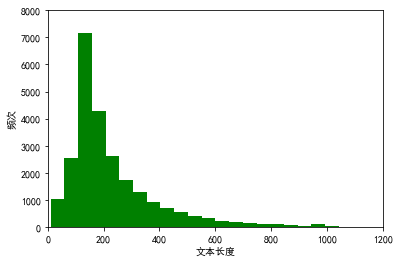

In [12]:
import matplotlib
matplotlib.use('qt4agg')
# 默认字体
#matplotlib.rcParams['font.sans-serif'] = ['SimHei']
#matplotlib.rcParams['font.family'] = 'sans-serif'
%matplotlib inline
matplotlib.pyplot.hist(num_words,50,facecolor = 'g')
matplotlib.pyplot.xlabel('文本长度')
matplotlib.pyplot.ylabel('频次')
matplotlib.pyplot.axis([0,1200,0,8000])
matplotlib.pyplot.show()

- 大部分文本都在230以内  设置max_seq_num = 300

- 将文本生成一个索引矩阵，并得到一个 25000 * 300  的矩阵 

In [13]:
import re
strip_special_chars = re.compile("[^A-Za-z0-9 ]+")
num_dimensions = 300  # Dimensions for each word vector


def cleanSentences(string):
    string = string.lower().replace("<br />", " ")
    return re.sub(strip_special_chars, "", string.lower())

max_seq_num = 300
ids = np.zeros((num_files, max_seq_num), dtype='int32')
file_count = 0
for pf in pos_files:
  with open(pf, "r", encoding='utf-8') as f:
    indexCounter = 0
    line = f.readline()
    cleanedLine = cleanSentences(line)
    split = cleanedLine.split()
    for word in split:
      try:
        ids[file_count][indexCounter] = wordsList.index(word)
      except ValueError:
        ids[file_count][indexCounter] = 399999  # 未知的词
      indexCounter = indexCounter + 1
      if indexCounter >= max_seq_num:
        break
    file_count = file_count + 1

for nf in neg_files:
  with open(nf, "r",encoding='utf-8') as f:
    indexCounter = 0
    line = f.readline()
    cleanedLine = cleanSentences(line)
    split = cleanedLine.split()
    for word in split:
      try:
        ids[file_count][indexCounter] = wordsList.index(word)
      except ValueError:
        ids[file_count][indexCounter] = 399999  # 未知的词语
      indexCounter = indexCounter + 1
      if indexCounter >= max_seq_num:
        break
    file_count = file_count + 1

np.save('idsMatrix', ids)



### 辅助函数

In [14]:
from random import randint
def get_train_batch():
    labels = []
    arr = np.zeros([batch_size, max_seq_num])
    for i in range(batch_size):
        if (i % 2 == 0):
            num = randint(1, 11499)
            labels.append([1, 0])
        else:
            num = randint(13499, 24999)
            labels.append([0, 1])
        arr[i] = ids[num - 1:num]
    return arr, labels


def get_test_batch():
    labels = []
    arr = np.zeros([batch_size, max_seq_num])
    for i in range(batch_size):
        num = randint(11499, 13499)
        if (num <= 12499):
            labels.append([1, 0])
        else:
            labels.append([0, 1])
        arr[i] = ids[num - 1:num]
    return arr, labels


## 模型设置
- 构建tf，定义超参数

In [15]:
batch_size = 24
lstm_units = 64
num_labels = 2
iterations = 100
lr = 0.001
ids = np.load('idsMatrix.npy')

In [17]:
import tensorflow as tf
tf.reset_default_graph()
labels = tf.placeholder(tf.float32, [batch_size, num_labels])
input_data = tf.placeholder(tf.int32, [batch_size, max_seq_num])

- 设置好占位符 tf.placeholder之后，调用tf.nn.lookup()获得文本向量，该函数会返回 batch_size 的3D张量。 见书156

In [19]:
data = tf.Variable(
    tf.zeros([batch_size, max_seq_num, num_dimensions]), dtype=tf.float32)
data = tf.nn.embedding_lookup(wordVectors, input_data)
data.shape

TensorShape([Dimension(24), Dimension(300), Dimension(50)])

### 配置LSTM网络
- rnn.BasicLSTMCell LSTM细胞单元
- nn.dynamic_rnn展开网络，构建RNN模型

In [1]:
lstmCell = tf.contrib.rnn.BasicLSTMCell(lstm_units)
lstmCell = tf.contrib.rnn.DropoutWrapper(cell=lstmCell, output_keep_prob=0.5)
value, _ = tf.nn.dynamic_rnn(lstmCell, data, dtype=tf.float32)

NameError: name 'tf' is not defined

- 重新确定维度

In [ ]:
weight = tf.Variable(tf.truncated_normal([lstm_units, num_labels]))
bias = tf.Variable(tf.constant(0.1, shape=[num_labels]))
value = tf.transpose(value, [1, 0, 2])
last = tf.gather(value, int(value.get_shape()[0]) - 1)
prediction = (tf.matmul(last, weight) + bias)


- 定义正确率  预测函数  

In [ ]:
correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(labels, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

- 损失值 --交叉熵损失函数   Adam优化函数

In [ ]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=prediction, labels=labels))
optimizer = tf.train.AdamOptimizer(lr).minimize(loss)

### 训练

In [ ]:
saver = tf.train.Saver()

with tf.Session() as sess:
    if os.path.exists("models") and os.path.exists("models/checkpoint"):
        saver.restore(sess, tf.train.latest_checkpoint('models'))
    else:
        if int((tf.__version__).split('.')[1]) < 12 and int((tf.__version__).split('.')[0]) < 1:
            init = tf.initialize_all_variables()
        else:
            init = tf.global_variables_initializer()
        sess.run(init)

    iterations = 100
    for step in range(iterations):
        next_batch, next_batch_labels = get_test_batch()
        if step % 20 == 0:
            print("step:", step, " 正确率:", (sess.run(
                accuracy, {input_data: next_batch, labels: next_batch_labels})) * 100)

    if not os.path.exists("models"):
        os.mkdir("models")
    save_path = saver.save(sess, "models/model.ckpt")
    print("Model saved in path: %s" % save_path)
